# Multitask GP Regression

This notebook demonstrates how to perform standard (Kronecker) multitask regression with kernels.IndexKernel.

This differs from the [hadamard_multitask_gp_regression example notebook](https://github.com/cornellius-gp/gpytorch/blob/master/examples/hadamard_multitask_gp_regression.ipynb) in one key way:
- Here, we assume that we want to learn **all tasks per input**. (The kernel that we learn is expressed as a Kronecker product of an input kernel and a task kernel).
- In the other notebook, we assume that we want to learn one tasks per input.  For each input, we specify the task of the input that we care about. (The kernel in that notebook is the Hadamard product of an input kernel and a task kernel).

Multitask regression, first introduced in [this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf) learns similarities in the outputs simultaneously. It's useful when you are performing regression on multiple functions that share the same inputs, especially if they have similarities (such as being sinusodial). 

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Training points are every 0.1 in [0,1] (note that they're the same for both tasks)
train_x = torch.linspace(0, 1, 100)

# y1 function is sin(2*pi*x) with noise N(0, 0.04)
train_y1 = torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2
# y2 function is cos(2*pi*x) with noise N(0, 0.04)
train_y2 = torch.cos(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

# Create a train_y which interleaves the two
train_y = torch.stack([train_y1, train_y2], -1)

In [3]:
from torch import optim
from gpytorch.kernels import RBFKernel, MultitaskKernel
from gpytorch.means import ConstantMean, MultitaskMean
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.random_variables import MultitaskGaussianRandomVariable

In [4]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = MultitaskMean(ConstantMean(), n_tasks=2)
        self.data_covar_module = RBFKernel()
        self.covar_module = MultitaskKernel(self.data_covar_module, n_tasks=2, rank=1)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultitaskGaussianRandomVariable(mean_x, covar_x)

# Gaussian likelihood is used for regression to give predictive mean+variance
# and learn noise
likelihood = MultitaskGaussianLikelihood(n_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    # Zero prev backpropped gradients
    optimizer.zero_grad()
    # Make predictions from training data
    # Again, note feeding duplicated x_data and indices indicating which task
    output = model(train_x)
    # TODO: Fix this view call!!
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 47.475
Iter 2/50 - Loss: 42.576
Iter 3/50 - Loss: 37.770
Iter 4/50 - Loss: 32.467
Iter 5/50 - Loss: 27.739
Iter 6/50 - Loss: 22.835
Iter 7/50 - Loss: 17.893
Iter 8/50 - Loss: 13.256
Iter 9/50 - Loss: 8.723
Iter 10/50 - Loss: 3.679
Iter 11/50 - Loss: -0.692
Iter 12/50 - Loss: -5.358
Iter 13/50 - Loss: -9.824
Iter 14/50 - Loss: -14.989
Iter 15/50 - Loss: -19.622
Iter 16/50 - Loss: -22.715
Iter 17/50 - Loss: -27.481
Iter 18/50 - Loss: -31.461
Iter 19/50 - Loss: -33.751
Iter 20/50 - Loss: -39.969
Iter 21/50 - Loss: -43.341
Iter 22/50 - Loss: -48.311
Iter 23/50 - Loss: -53.446
Iter 24/50 - Loss: -56.509
Iter 25/50 - Loss: -60.245
Iter 26/50 - Loss: -63.103
Iter 27/50 - Loss: -67.625
Iter 28/50 - Loss: -71.480
Iter 29/50 - Loss: -73.560
Iter 30/50 - Loss: -76.069
Iter 31/50 - Loss: -80.834
Iter 32/50 - Loss: -82.028
Iter 33/50 - Loss: -85.708
Iter 34/50 - Loss: -88.573
Iter 35/50 - Loss: -91.192
Iter 36/50 - Loss: -92.010
Iter 37/50 - Loss: -94.762
Iter 38/50 - Loss: -95.25

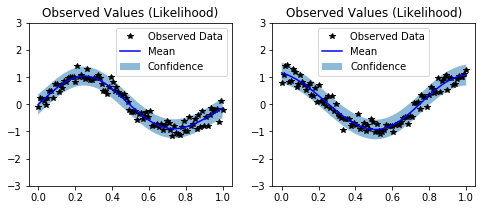

In [6]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))
# Test points every 0.02 in [0,1]

# Make predictions
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))
    # Get mean
    mean = observed_pred.mean()
    # Get lower and upper confidence bounds
    lower, upper = observed_pred.confidence_region()
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Define plotting function
def ax_plot():

    # Plot training data as black stars
    y1_ax.plot(train_x.detach().numpy(), train_y1.detach().numpy(), 'k*')
    # Predictive mean as blue line
    y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
    # Shade in confidence 
    y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
    y1_ax.set_ylim([-3, 3])
    y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y1_ax.set_title('Observed Values (Likelihood)')
    
    # Plot training data as black stars
    y2_ax.plot(train_x.detach().numpy(), train_y2.detach().numpy(), 'k*')
    # Predictive mean as blue line
    y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
    # Shade in confidence 
    y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
    y2_ax.set_ylim([-3, 3])
    y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y2_ax.set_title('Observed Values (Likelihood)')

# Plot both tasks
ax_plot()